In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, SimpleRNN, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import KFold


In [18]:
# Load the dataset
data = pd.read_csv('https://archive.ics.uci.edu/static/public/911/data.csv')
data.head()

,num_records,recipe_number,recipe_code,recipe_name,comment_id,user_id,user_name,user_reputation,created_at,reply_count,thumbs_up,thumbs_down,stars,best_score,text
0,0,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,5,527,"I tweaked it a little, removed onions because ..."
1,1,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,5,724,Bush used to have a white chili bean and it ma...
2,2,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,5,710,I have a very complicated white chicken chili ...
3,3,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DzdSIgV9qNiuBaLoZ7JQaartoC,u_fqrybAdYjgjG,jeansch123,1,1661787808,2,2,0,0,581,"In your introduction, you mentioned cream chee..."
4,4,1,14299,Creamy White Chili,sp_aUSaElGf_14299_c_2DtZJuRQYeTFwXBoZRfRhBPEXjI,u_XXWKwVhKZD69,camper77,10,1664913823,1,7,0,0,820,Wonderful! I made this for a &#34;Chili/Stew&#...


In [21]:
# Preprocessing steps for the 'review_text' column
data['review_text'] = data['text'].str.lower()
data['review_text'] = data['review_text'].str.replace(r'[^\w\s]', '', regex=True)
data['review_text'] = data['review_text'].str.replace(r'\d+', '', regex=True)
data = data.dropna(subset=['review_text', 'best_score'])

In [24]:
data = data[data['stars'] >= 1]

In [ ]:
from gensim.models import Word2Vec

# Word2Vec Embedding
sentences = data['review_text'].apply(lambda x: x.split()).tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Correct the vocab_size to include an additional padding index
vocab_size = len(word2vec_model.wv) + 1  # Add 1 for padding index

# Initialize the embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))

# Map words to indices and populate the embedding matrix
word_index = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}  # Start indexing from 1
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

#stars 1-5 as y

In [ ]:

X = data['review_text']
y = data['stars'].values - 1
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenization for RNN and BiRNN
def texts_to_sequences(texts, word_index):
    return [[word_index.get(word, 0) for word in text.split()] for text in texts]

X_train_seq = texts_to_sequences(X_train, word_index)
X_test_seq = texts_to_sequences(X_test, word_index)
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=200)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=200)

# Build Simple RNN model using Sequential API
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
    SimpleRNN(64, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

rnn_optimizer = Adam(learning_rate=0.001)
rnn_model.compile(optimizer=rnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Simple RNN model
rnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/5


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7141 - loss: 1.0054 - val_accuracy: 0.8392 - val_loss: 0.5859
Epoch 2/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8393 - loss: 0.6164 - val_accuracy: 0.8392 - val_loss: 0.5642
Epoch 3/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8378 - loss: 0.5814 - val_accuracy: 0.8392 - val_loss: 0.5455
Epoch 4/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8392 - loss: 0.5614 - val_accuracy: 0.8389 - val_loss: 0.5311
Epoch 5/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8405 - loss: 0.5406 - val_accuracy: 0.8389 - val_loss: 0.5262


In [31]:
# Build BiRNN model using Sequential API
birnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

birnn_optimizer = RMSprop(learning_rate=0.001)
birnn_model.compile(optimizer=birnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train BiRNN model
birnn_model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))


Epoch 1/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.8226 - loss: 0.6409 - val_accuracy: 0.8392 - val_loss: 0.5060
Epoch 2/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.8421 - loss: 0.5022 - val_accuracy: 0.8399 - val_loss: 0.4789
Epoch 3/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 69ms/step - accuracy: 0.8352 - loss: 0.4987 - val_accuracy: 0.8411 - val_loss: 0.4895
Epoch 4/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.8400 - loss: 0.4697 - val_accuracy: 0.8423 - val_loss: 0.4500
Epoch 5/5
413/413 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.8410 - loss: 0.4502 - val_accuracy: 0.8411 - val_loss: 0.4722


In [32]:
# Evaluation Function
def evaluate_model(model, X_test, y_test, model_type="RNN"):
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
    print(f"Accuracy ({model_type}): {accuracy}")
    print(f"Classification Report ({model_type}):\n{report}")


In [33]:
# Evaluate Simple RNN
evaluate_model(rnn_model, X_test_pad, y_test, model_type="Simple RNN")


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy (Simple RNN): 0.8389444949954504
Classification Report (Simple RNN):
              precision    recall  f1-score   support

     class_0       0.00      0.00      0.00        63
     class_1       0.00      0.00      0.00        41
     class_2       0.00      0.00      0.00        98
     class_3       0.00      0.00      0.00       328
     class_4       0.84      1.00      0.91      2767

    accuracy                           0.84      3297
   macro avg       0.17      0.20      0.18      3297
weighted avg       0.70      0.84      0.77      3297



/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:
# Evaluate BiRNN
evaluate_model(birnn_model, X_test_pad, y_test, model_type="BiRNN")

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy (BiRNN): 0.8410676372459812
Classification Report (BiRNN):
              precision    recall  f1-score   support

     class_0       0.39      0.17      0.24        63
     class_1       0.20      0.10      0.13        41
     class_2       0.22      0.38      0.27        98
     class_3       0.54      0.08      0.13       328
     class_4       0.89      0.97      0.93      2767

    accuracy                           0.84      3297
   macro avg       0.45      0.34      0.34      3297
weighted avg       0.82      0.84      0.81      3297



In [41]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = data['review_text']
y = data['stars'].values -1

# Initialize results storage
rnn_f1_scores = []
birnn_f1_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Tokenize and pad sequences
    X_train_seq = texts_to_sequences(X_train, word_index)
    X_test_seq = texts_to_sequences(X_test, word_index)
    X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=200)
    X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=200)

    # Build and train Simple RNN model
    rnn_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
        SimpleRNN(64, return_sequences=False, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    rnn_optimizer = Adam(learning_rate=0.001)
    rnn_model.compile(optimizer=rnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    rnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

    # Predict and calculate F1 for RNN
    rnn_predictions = np.argmax(rnn_model.predict(X_test_pad), axis=1)
    rnn_f1 = f1_score(y_test, rnn_predictions, average='weighted')
    rnn_f1_scores.append(rnn_f1)

    # Build and train BiRNN model
    birnn_model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=100, input_length=200, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(64, return_sequences=False, activation='tanh')),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    birnn_optimizer = RMSprop(learning_rate=0.001)
    birnn_model.compile(optimizer=birnn_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    birnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, verbose=0)

    # Predict and calculate F1 for BiRNN
    birnn_predictions = np.argmax(birnn_model.predict(X_test_pad), axis=1)
    birnn_f1 = f1_score(y_test, birnn_predictions, average='weighted')
    birnn_f1_scores.append(birnn_f1)

# Print cross-validation results
print(f"RNN Average F1 Score (5-fold CV): {np.mean(rnn_f1_scores)}")
print(f"BiRNN Average F1 Score (5-fold CV): {np.mean(birnn_f1_scores)}")

/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


/Users/huiyisang/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
RNN Average F1 Score (5-fold CV): 0.7664005186325209
BiRNN Average F1 Score (5-fold CV): 0.7767045115270508


In [42]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
# Predict using Simple RNN
rnn_predictions = rnn_model.predict(X_test_pad)
rnn_pred_classes = rnn_predictions.argmax(axis=1)  # Convert probabilities to class indices

# Predict using BiRNN
birnn_predictions = birnn_model.predict(X_test_pad)
birnn_pred_classes = birnn_predictions.argmax(axis=1)  # Convert probabilities to class indices

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [44]:
# Generate confusion matrices
rnn_cm = confusion_matrix(y_test, rnn_pred_classes)
birnn_cm = confusion_matrix(y_test, birnn_pred_classes)

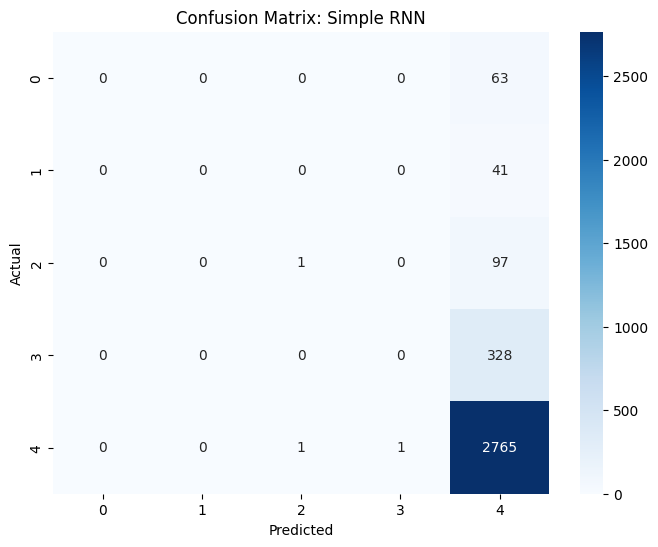

In [46]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(rnn_cm, "Confusion Matrix: Simple RNN")

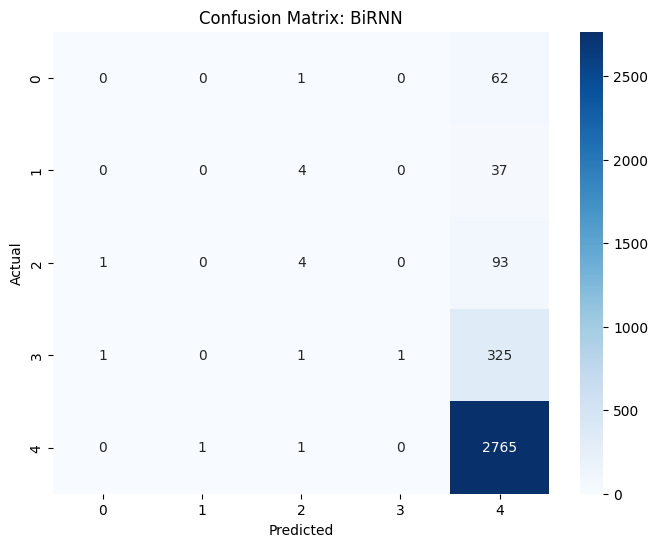

In [47]:
plot_confusion_matrix(birnn_cm, "Confusion Matrix: BiRNN")